In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import numpy as np
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

# Reproducibility
import scvi
from scvi.external import SysVI

# Define the path to the directory you want to change to
new_directory = '/scratch365/eaboelno/cVAE_analysis/sysVI/'

# Use os.chdir() to change the working directory
os.chdir(new_directory)

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.1

In [2]:
adata = sc.read_h5ad('./adata_mm_merged_cr6kHVG.h5ad')
adata

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

# Set up data

In [3]:
adata.obs

sample_id       publication   sample_id_anon  \
barcode                                                                     
GTATTTCGTCCACATA-1_adams           cl2      (this study)  adams_Sample6_2   
ATACCTTGTCGACGCT-1_adams           cl2      (this study)  adams_Sample6_2   
TCAAGACGTGCTGCAC-1_adams           cl2      (this study)  adams_Sample6_2   
AGTACTGTCAAGTAAG-1_adams           cl2      (this study)  adams_Sample6_2   
TCCCAGTTCCGATGCG-1_adams           cl2      (this study)  adams_Sample6_2   
...                                ...               ...              ...   
ACGATGTTCCCTAACC-1_shen    SRR11546853  Shen et al. 2021  shen_Sample27_3   
GCATGTAAGGTAGCTG-1_shen    SRR11546853  Shen et al. 2021  shen_Sample27_3   
TTCTACACATGCCTTC-1_shen    SRR11546853  Shen et al. 2021  shen_Sample27_3   
ATCACGAAGGGCTCTC-1-1_shen  SRR11546853  Shen et al. 2021  shen_Sample27_3   
GTTCGGGTCAATAAGG-1_shen    SRR11546853  Shen et al. 2021  shen_Sample27_3   

                          individual_id_anon replicate treatment  \
barcode                                                            
GTATTTCGTCCACATA-1_adams       adams_Sample6         2       LPC   
ATACCTTGTCGACGCT-1_adams       adams_Sample6         2       LPC   
TCAAGACGTGCTGCAC-1_adams       adams_Sample6         2       LPC   
AGTACTGTCAAGTAAG-1_adams       adams_Sample6         2       LPC   
TCCCAGTTCCGATGCG-1_adams       adams_Sample6         2       LPC   
...                                      ...       ...       ...   
ACGATGTTCCCTAACC-1_shen        shen_Sample27         3    Normal   
GCATGTAAGGTAGCTG-1_shen        shen_Sample27         3    Normal   
TTCTACACATGCCTTC-1_shen        shen_Sample27         3    Normal   
ATCACGAAGGGCTCTC-1-1_shen      shen_Sample27         3    Normal   
GTTCGGGTCAATAAGG-1_shen        shen_Sample27         3    Normal   

                               condition           tissue      time batch  \
barcode                                                                     
GTATTTCGTCCACATA-1_adams   Demyelination  Corpus callosum      7dpl     6   
ATACCTTGTCGACGCT-1_adams   Demyelination  Corpus callosum      7dpl     6   
TCAAGACGTGCTGCAC-1_adams   Demyelination  Corpus callosum      7dpl     6   
AGTACTGTCAAGTAAG-1_adams   Demyelination  Corpus callosum      7dpl     6   
TCCCAGTTCCGATGCG-1_adams   Demyelination  Corpus callosum      7dpl     6   
...                                  ...              ...       ...   ...   
ACGATGTTCCCTAACC-1_shen          Control  Corpus callosum  Baseline    27   
GCATGTAAGGTAGCTG-1_shen          Control  Corpus callosum  Baseline    27   
TTCTACACATGCCTTC-1_shen          Control  Corpus callosum  Baseline    27   
ATCACGAAGGGCTCTC-1-1_shen        Control  Corpus callosum  Baseline    27   
GTTCGGGTCAATAAGG-1_shen          Control  Corpus callosum  Baseline    27   

                           ... age_scale age_cat pmi_cat  pmi_cat2  \
barcode                    ...                                       
GTATTTCGTCCACATA-1_adams   ...         0   adult    None      None   
ATACCTTGTCGACGCT-1_adams   ...         0   adult    None      None   
TCAAGACGTGCTGCAC-1_adams   ...         0   adult    None      None   
AGTACTGTCAAGTAAG-1_adams   ...         0   adult    None      None   
TCCCAGTTCCGATGCG-1_adams   ...         0   adult    None      None   
...                        ...       ...     ...     ...       ...   
ACGATGTTCCCTAACC-1_shen    ...         0   adult    None      None   
GCATGTAAGGTAGCTG-1_shen    ...         0   adult    None      None   
TTCTACACATGCCTTC-1_shen    ...         0   adult    None      None   
ATCACGAAGGGCTCTC-1-1_shen  ...         0   adult    None      None   
GTTCGGGTCAATAAGG-1_shen    ...         0   adult    None      None   

                           cell_cycle_diff      cell_type_eval  \
barcode                                                          
GTATTTCGTCCACATA-1_adams         -0.039946  excitatory neurons   
ATACCTTGTCGACGCT-1_adams       

In [4]:
system_map = {
    '(this study)': '0',
    'Pandey et al. 2022': '1',
    'Shen et al. 2021': '1'
}

# Update the 'system_map' column based on the mapping
adata.obs['system'] = adata.obs['publication'].map(system_map)

In [5]:
system_map = {
    '0': 'sn-mouse',
    '1': 'sc-mouse'
}

# Convert keys of system_map dictionary to integers
#system_map = {int(key): value for key, value in system_map.items()}

# Update the 'system_map' column based on the mapping
adata.obs['system_map'] = adata.obs['system'].map(system_map)

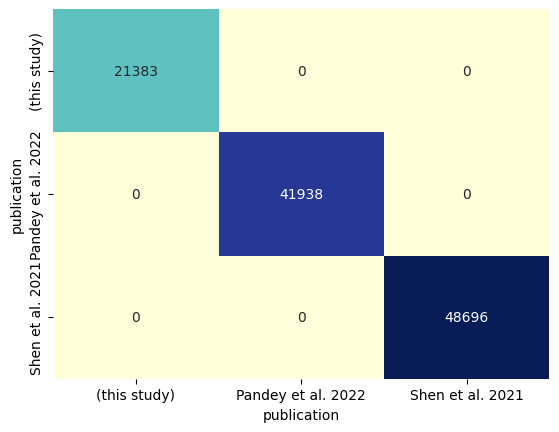

In [6]:
crosstab_df = pd.crosstab(adata.obs.publication, adata.obs.publication)

# Create the heatmap with integer annotations
sb.heatmap(crosstab_df, cmap="YlGnBu", annot=True, fmt="d", cbar=False)

# Show the heatmap
plt.show()

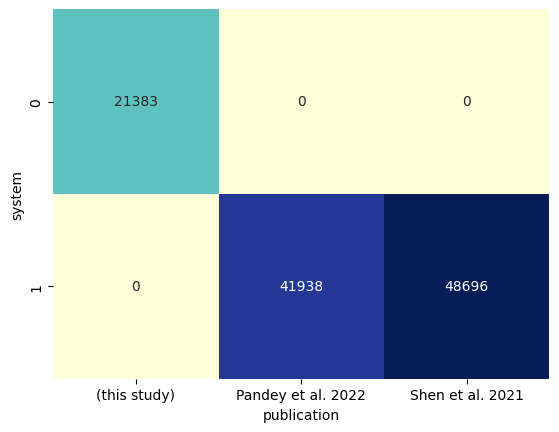

In [7]:
crosstab_df = pd.crosstab(adata.obs.system, adata.obs.publication)

# Create the heatmap with integer annotations
sb.heatmap(crosstab_df, cmap="YlGnBu", annot=True, fmt="d", cbar=False)

# Show the heatmap
plt.show()

# Initiate model

In [8]:
adata

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [9]:
# Setup adata for training
SysVI.setup_anndata(
    adata=adata,
    batch_key="system",
    categorical_covariate_keys=["batch"],
)

INFO     Using column names from columns of adata.obsm['system']                                                   
INFO     Using column names from columns of adata.obsm['covariates']                                               


In [10]:
# Initialise the model
model = SysVI(adata=adata)

INFO     The model has been initialized                                                                            


In [11]:
# Train
max_epochs = 200
model.train(
    max_epochs=max_epochs,
    # Parameters used for checking losses
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    val_check_interval=1.0,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 200/200: 100%|█| 200/200 [49:17<00:00, 15.57s/it, v_num=1, loss_train=-5.4

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [49:17<00:00, 14.79s/it, v_num=1, loss_train=-5.4


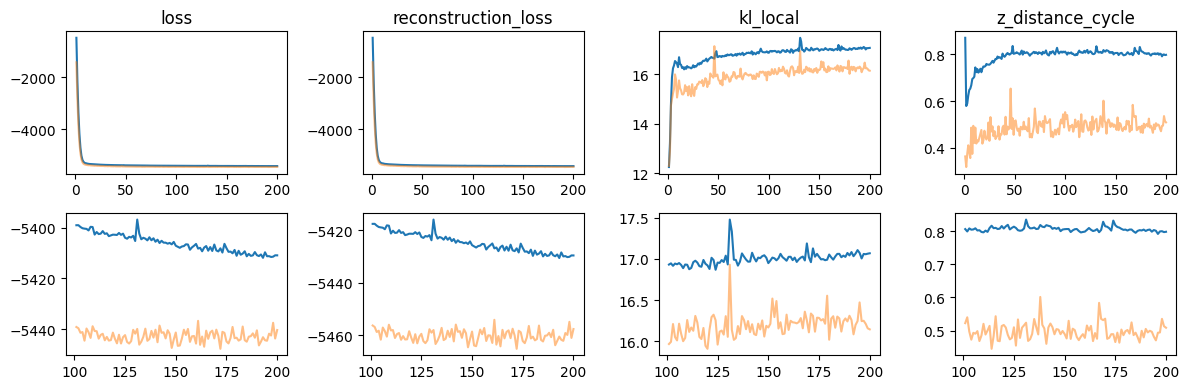

In [12]:
# Plot loses
# The plotting code below was specifcally adapted to the above specified model and its training
# If changing the model or training the plotting functions may need to be addapted accordingly

# Make detailed plot after N epochs
epochs_detail_plot = 100
steps_detail_plot = epochs_detail_plot * int(
    model.trainer.logger.history["loss_validation"].shape[0] / max_epochs
)
detail_plot = epochs_detail_plot

# Losses to plot
losses = [
    "loss_train",
    "reconstruction_loss_train",
    "kl_local_train",
    "z_distance_cycle_train",
]
fig, axs = plt.subplots(2, len(losses), figsize=(len(losses) * 3, 4))
for ax_i, l_train in enumerate(losses):
    l_val = l_train.replace("_train", "_validation")
    l_name = l_train.replace("_train", "")
    # Change idx of epochs to start with 1 so that below adjustment when
    # train on step which only works for val leads to appropriate multiplication
    l_val_values = model.trainer.logger.history[l_val].copy()
    l_val_values.index = l_val_values.index + 1
    l_train_values = model.trainer.logger.history[l_train].copy()
    l_train_values.index = l_train_values.index + 1
    # This happens if log on step as currently this works only for val loss
    if l_train_values.shape[0] < l_val_values.shape[0]:
        l_train_values.index = l_train_values.index * int(
            l_val_values.shape[0] / l_train_values.shape[0]
        )
    for l_values, c, alpha, dp in [
        # Train loss logged on epoch in either case now
        (l_train_values, "tab:blue", 1, epochs_detail_plot),
        (l_val_values, "tab:orange", 0.5, detail_plot),
    ]:
        axs[0, ax_i].plot(l_values.index, l_values.values.ravel(), c=c, alpha=alpha)
        axs[0, ax_i].set_title(l_name)
        axs[1, ax_i].plot(
            l_values.index[dp:], l_values.values.ravel()[dp:], c=c, alpha=alpha
        )

fig.tight_layout()

# Adapt the adata directly like in scVI

In [27]:
adata

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2', 'sys_leiden_new_1', 'sys_leiden_new_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'co

In [14]:
SYSVI_LATENT_KEY = "X_sysVI"
adata.obsm[SYSVI_LATENT_KEY] = model.get_latent_representation(adata=adata)

In [15]:
sc.pp.neighbors(adata, use_rep = 'X_sysVI', n_neighbors=30) #can go up if the dataset is very large
sc.tl.umap(adata, min_dist=0.2) #increase min_dist reduces general features 
sc.tl.leiden(adata, resolution=0.5, key_added="sys_leiden_0.5")
sc.tl.leiden(adata, resolution=1, key_added="sys_leiden_1")
sc.tl.leiden(adata, resolution=1.5, key_added="sys_leiden_1.5")
sc.tl.leiden(adata, resolution=2, key_added="sys_leiden_2")

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

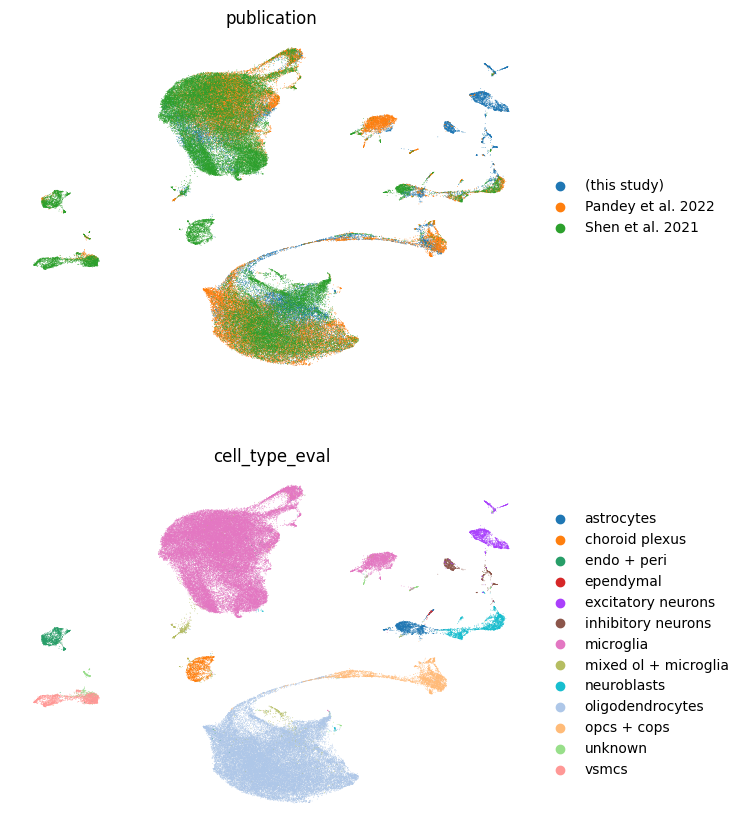

In [16]:
sc.pl.embedding(
    adata,
    basis='X_umap',
    color=["publication", "cell_type_eval"],
    frameon=False,
    ncols=1,
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

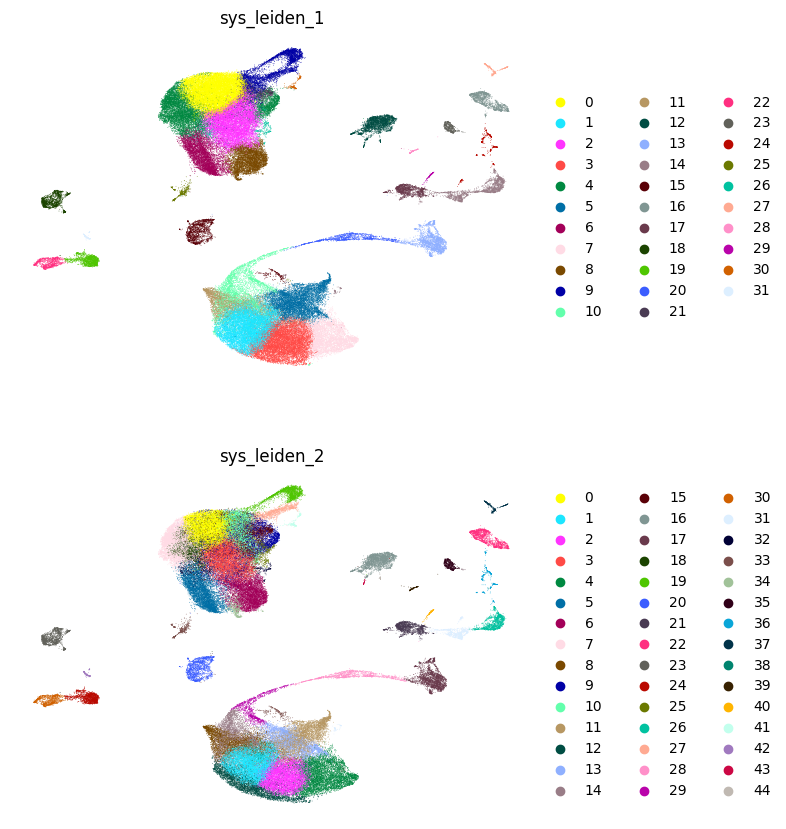

In [17]:
sc.pl.embedding(
    adata,
    basis='X_umap',
    color=["sys_leiden_1", "sys_leiden_2"],
    frameon=False,
    ncols=1,
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/sc

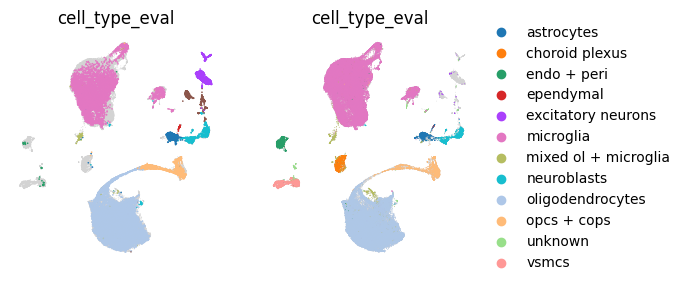

In [19]:
# Plot UMAP embedding per system
systems = sorted(adata.obs.system.unique())
ncols = len(systems)
# Plot systems side by side
fig, axs = plt.subplots(1, ncols, figsize=(3 * ncols, 3))
for i, system in enumerate(systems):
    ax = axs[i]
    # Plot all cells as background and on top cells from one system colored by cell type
    sc.pl.umap(adata, ax=ax, show=False, frameon=False)
    sc.pl.umap(
        adata[adata.obs.system == system, :],
        color="cell_type_eval",
        ax=ax,
        show=False,
        frameon=False,
        #title=system,  # Fix: Use `system` instead of `systems`
    )
    # Keep legend only on the last plot (assuming this legend contains all categories)
    if i != ncols - 1:
        ax.get_legend().remove()

In [20]:
adata

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'layer_information', 'system_order', 'covariate_categ_orders', 'covariate_key_orders', '_scvi_uui

In [21]:
model.save('sysVI_mouse_only_model')

In [22]:
system_data = adata.obsm['system']
print(system_data)

0    1
barcode                            
GTATTTCGTCCACATA-1_adams   1.0  0.0
ATACCTTGTCGACGCT-1_adams   1.0  0.0
TCAAGACGTGCTGCAC-1_adams   1.0  0.0
AGTACTGTCAAGTAAG-1_adams   1.0  0.0
TCCCAGTTCCGATGCG-1_adams   1.0  0.0
...                        ...  ...
ACGATGTTCCCTAACC-1_shen    0.0  1.0
GCATGTAAGGTAGCTG-1_shen    0.0  1.0
TTCTACACATGCCTTC-1_shen    0.0  1.0
ATCACGAAGGGCTCTC-1-1_shen  0.0  1.0
GTTCGGGTCAATAAGG-1_shen    0.0  1.0

[112017 rows x 2 columns]

In [23]:
adata.obsm['system']

0    1
barcode                            
GTATTTCGTCCACATA-1_adams   1.0  0.0
ATACCTTGTCGACGCT-1_adams   1.0  0.0
TCAAGACGTGCTGCAC-1_adams   1.0  0.0
AGTACTGTCAAGTAAG-1_adams   1.0  0.0
TCCCAGTTCCGATGCG-1_adams   1.0  0.0
...                        ...  ...
ACGATGTTCCCTAACC-1_shen    0.0  1.0
GCATGTAAGGTAGCTG-1_shen    0.0  1.0
TTCTACACATGCCTTC-1_shen    0.0  1.0
ATCACGAAGGGCTCTC-1-1_shen  0.0  1.0
GTTCGGGTCAATAAGG-1_shen    0.0  1.0

[112017 rows x 2 columns]

In [24]:
# Change column names in obsm['system']
adata.obsm['system'].columns = ['mouse-sn', 'mouse-sc']

In [25]:
adata.write_h5ad('./sysVI_moues_only_output.h5ad')

# Reload data and make cell type specifc integrations

In [8]:
adata =sc.read_h5ad('./sysVI_moues_only_output.h5ad')
adata

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariate_categ_orders', 'covariate_key_or

In [9]:
model = SysVI.load('sysVI_mouse_only_model/', adata)

INFO     File sysVI_mouse_only_model/model.pt already downloaded                                                   
INFO     The model has been initialized                                                                            


In [ ]:
#SYSVI_LATENT_KEY = "X_sysVI"
#adata.obsm[SYSVI_LATENT_KEY] = model.get_latent_representation(adata=adata)

In [19]:
sc.pp.neighbors(adata, use_rep = 'X_sysVI', n_neighbors=30) #can go up if the dataset is very large; n_neighbors=15 default
sc.tl.umap(adata, min_dist = 0.15) #increase min_dist reduces general features, default 0.1
#sc.tl.leiden(adata, resolution=0.5, key_added="sys_leiden_0.5")
sc.tl.leiden(adata, resolution=1, key_added="sys_leiden_new_1")
#sc.tl.leiden(adata, resolution=1.5, key_added="sys_leiden_1.5")
sc.tl.leiden(adata, resolution=2, key_added="sys_leiden_new_2")

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

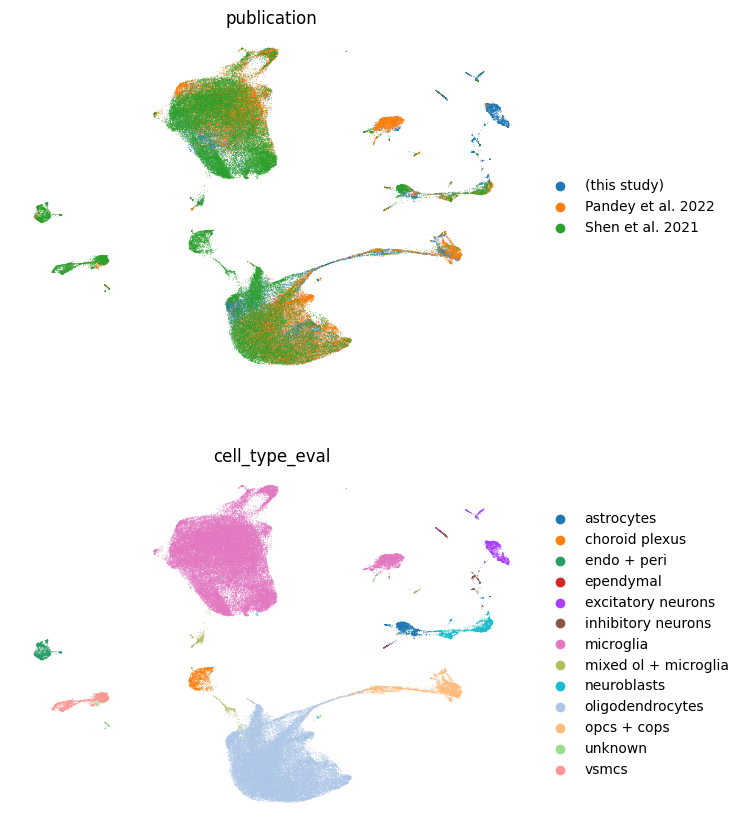

In [20]:
sc.pl.embedding(
    adata,
    basis='X_umap',
    color=["publication", "cell_type_eval"],
    frameon=False,
    ncols=1,
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

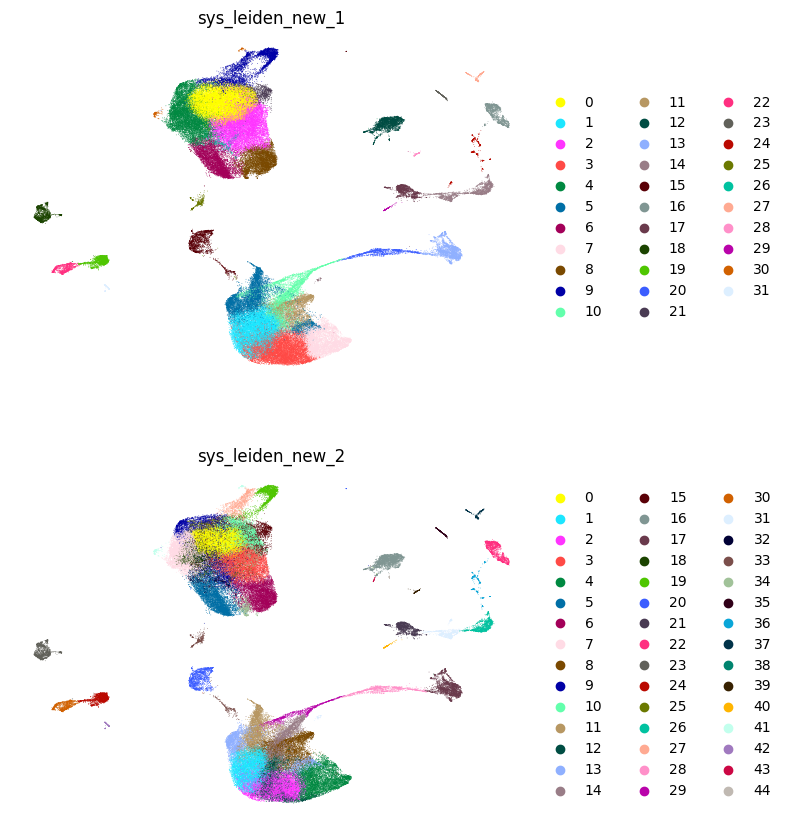

In [21]:
sc.pl.embedding(
    adata,
    basis='X_umap',
    color=["sys_leiden_new_1", "sys_leiden_new_2"],
    frameon=False,
    ncols=1,
)

In [22]:
sc.pp.neighbors(adata, use_rep = 'X_sysVI', n_neighbors=20) #can go up if the dataset is very large; n_neighbors=15 default
sc.tl.umap(adata) #increase min_dist reduces general features, default 0.1

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

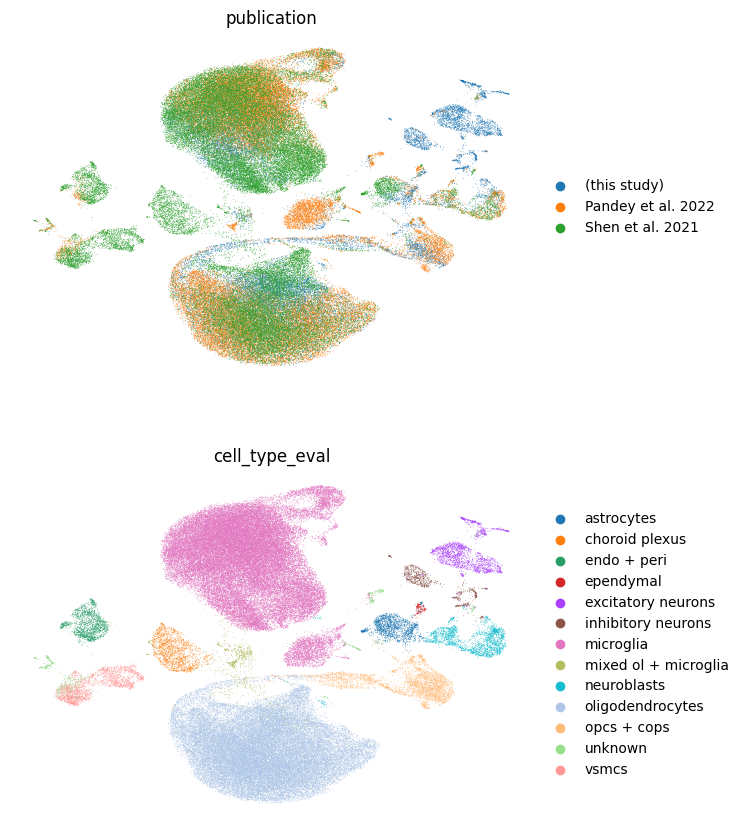

In [23]:
sc.pl.embedding(
    adata,
    basis='X_umap',
    color=["publication", "cell_type_eval"],
    frameon=False,
    ncols=1,
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

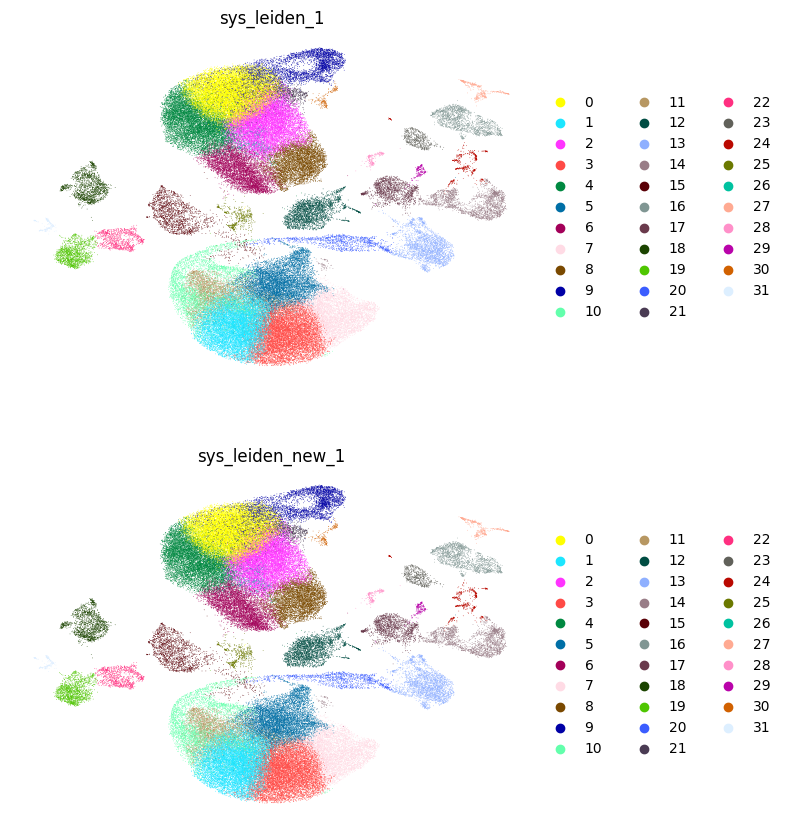

In [29]:
sc.pl.embedding(
    adata,
    basis='X_umap',
    color=["sys_leiden_1", "sys_leiden_new_1"],
    frameon=False,
    ncols=1,
)

In [30]:
adata.obs.drop(columns=['sys_leiden_new_1'], inplace=True)
adata.obs.drop(columns=['sys_leiden_new_2'], inplace=True)

In [31]:
adata

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariate_categ_orders', 'covariate_key_or

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

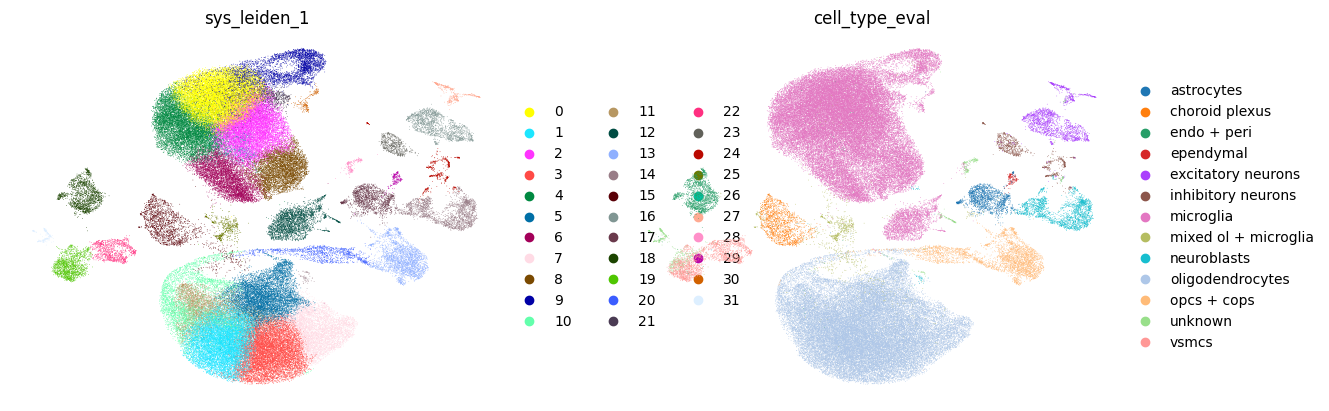

In [33]:
sc.pl.embedding(
    adata,
    basis='X_umap',
    color=["sys_leiden_1", "cell_type_eval"],
    frameon=False,
    ncols=2,
)

# Subset to oligo and recluster

In [34]:
desired_cell_types = ['opcs + cops', 'oligodendrocytes']
adata_ol = adata[adata.obs['cell_type_eval'].isin(desired_cell_types)].copy()
sc.pp.filter_genes(adata_ol, min_cells=1)
adata_ol

AnnData object with n_obs × n_vars = 44820 × 5997
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariate_categ_orders', 'covari

In [35]:
# Compute new UMAP
sc.pp.neighbors(adata_ol, use_rep="X_sysVI")
sc.tl.umap(adata_ol)
sc.tl.leiden(adata_ol, resolution=1, key_added="sys_OL_1")
sc.tl.leiden(adata_ol, resolution=2, key_added="sys_OL_2")
adata_ol

AnnData object with n_obs × n_vars = 44820 × 5997
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2', 'sys_OL_1', 'sys_OL_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariat

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

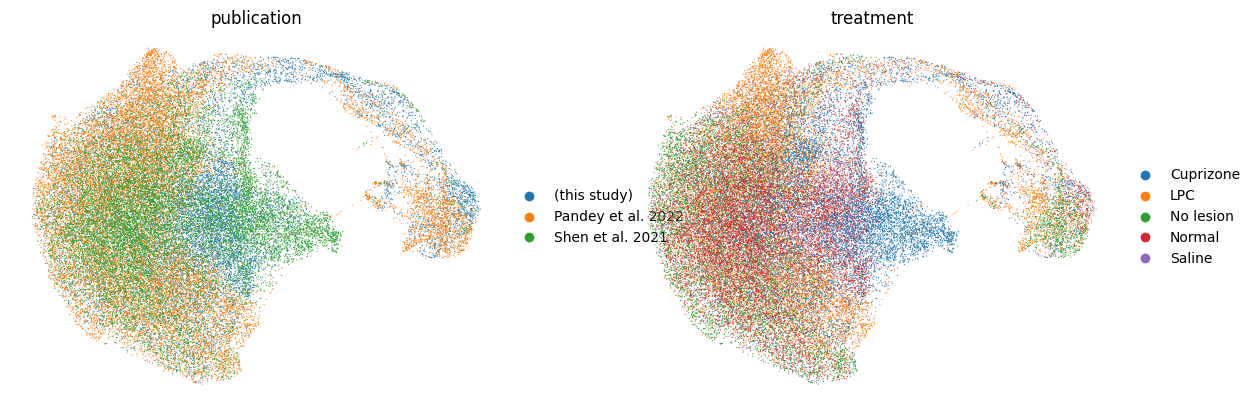

In [37]:
sc.pl.embedding(
    adata_ol,
    basis='X_umap',
    color=["publication", "treatment"],
    frameon=False,
    ncols=2,
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


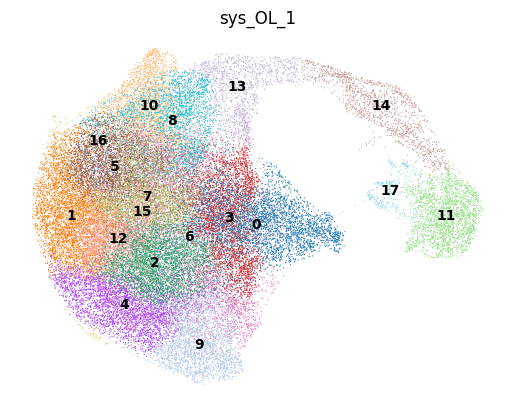

In [65]:
sc.pl.embedding(
    adata_ol,
    basis='X_umap',
    color=["sys_OL_1"],
    frameon=False,
    ncols=2,
    legend_loc="on data"
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

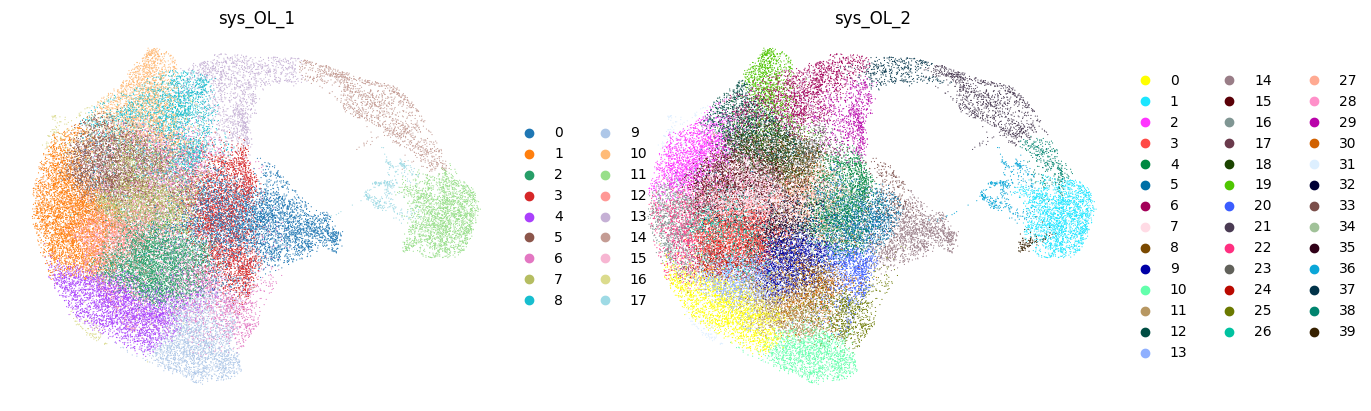

In [38]:
sc.pl.embedding(
    adata_ol,
    basis='X_umap',
    color=["sys_OL_1", "sys_OL_2"],
    frameon=False,
    ncols=2,
)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be r

categories: 0, 1, 2, etc.
var_group_labels: OL lineage, OPC markers, COP markers, etc.


/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


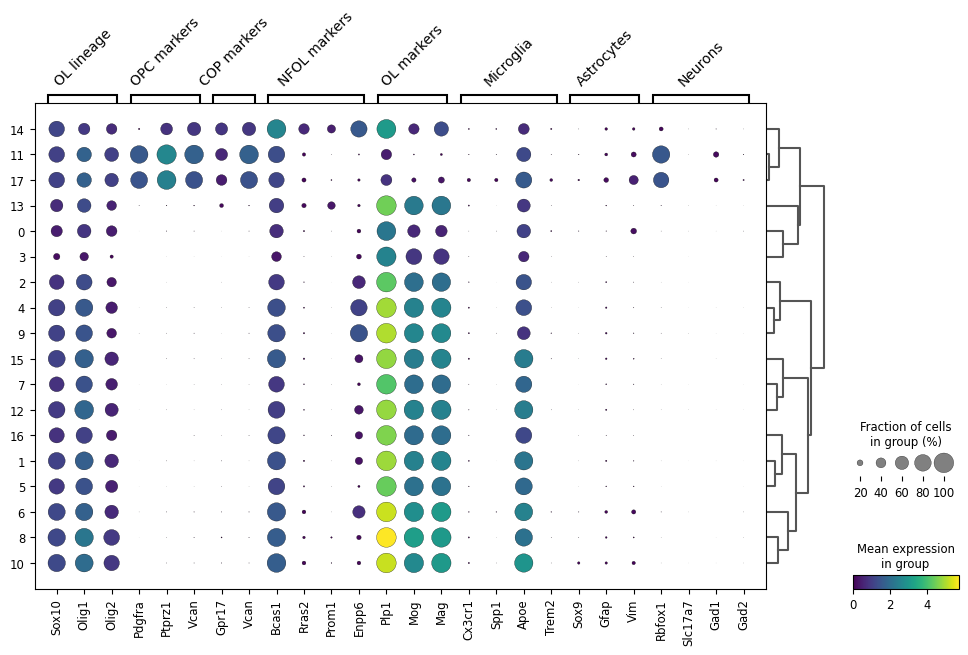

In [39]:
import pandas as pd

# Define marker genes with mouse gene names
marker_genes_mouse = {
    'OL lineage': ['Sox10', 'Olig1', 'Olig2'],
    'OPC markers': ['Pdgfra', 'Ptprz1', 'Vcan'],
    'COP markers': ['Gpr17', 'Vcan'],
    'NFOL markers': ['Bcas1', 'Rras2', 'Prom1', 'Enpp6'],
    'OL markers': ['Plp1', 'Mog', 'Mag'],
    'Microglia': ['Cx3cr1', 'Spp1', 'Apoe', 'Trem2'],
    'Astrocytes': ['Sox9', 'Gfap', 'Vim'],
    'Neurons': ['Rbfox1', 'Slc17a7', 'Gad1', 'Gad2']
}

# Flatten the list of genes in marker_genes while maintaining order
all_genes_mouse = [gene for genes in marker_genes_mouse.values() for gene in genes]

# Correct var_group_positions based on marker_genes_mouse
var_group_positions_mouse = []
start = 0
for genes in marker_genes_mouse.values():
    end = start + len(genes) - 1  # Calculate the end index for the group
    var_group_positions_mouse.append((start, end))  # Add the start and end index to var_group_positions_mouse
    start = end + 1  # Update the start index for the next group

# Plot the dotplot with the corrected parameters
sc.pl.dotplot(
    adata_ol,
    groupby="sys_OL_1",
    var_names=all_genes_mouse,
    use_raw=True,
    log=True,
    dendrogram=True,
    var_group_positions=var_group_positions_mouse,
    var_group_labels=list(marker_genes_mouse.keys()),
    var_group_rotation=45,
    standard_scale=None,  # Set to None to disable standard scaling
    swap_axes=False,  # Keep genes on the x-axis and cell types on the y-axis
    cmap='viridis',  # Choose a color map
    show=True
)


In [41]:
adata

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariate_categ_orders', 'covariate_key_or

In [40]:
adata_ol

AnnData object with n_obs × n_vars = 44820 × 5997
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2', 'sys_OL_1', 'sys_OL_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariat

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


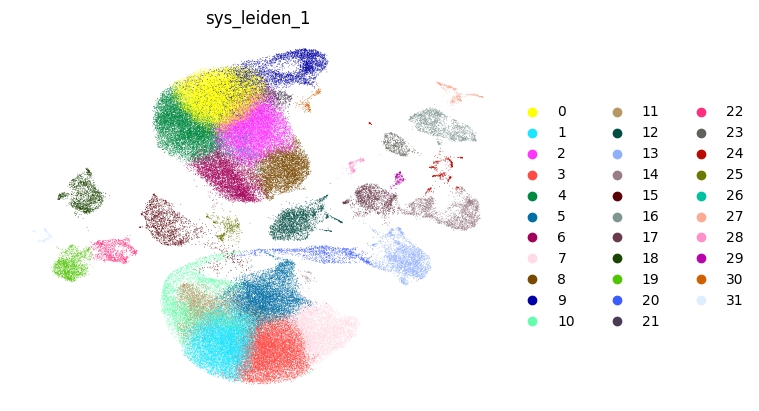

In [42]:
sc.pl.embedding(
    adata,
    basis='X_umap',
    color=["sys_leiden_1"],
    frameon=False,
    ncols=2,
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


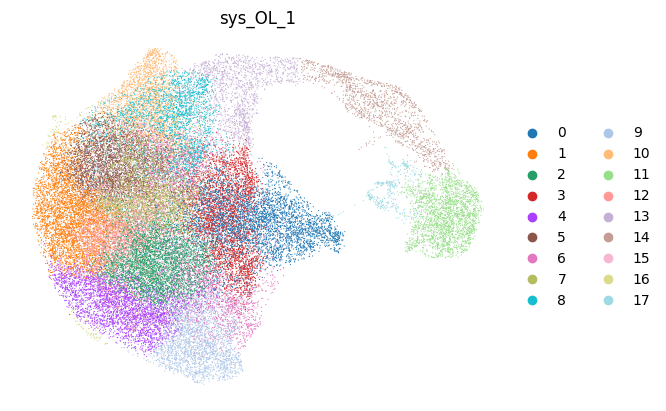

In [44]:
sc.pl.embedding(
    adata_ol,
    basis='X_umap',
    color=["sys_OL_1"],
    frameon=False,
    ncols=2,
)

In [45]:
adata.write_h5ad('./sysVI_mouse_only_refined.h5ad')

In [46]:
adata_ol.write_h5ad('./sysVI_mouse_only_OL.h5ad')

# Microglia

In [47]:
adata

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariate_categ_orders', 'covariate_key_or

In [48]:
desired_cell_types = ['microglia']
adata_mg = adata[adata.obs['cell_type_eval'].isin(desired_cell_types)].copy()
sc.pp.filter_genes(adata_mg, min_cells=1)
adata_mg

AnnData object with n_obs × n_vars = 52726 × 5993
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariate_categ_orders', 'covari

In [49]:
sc.pp.neighbors(adata_ol, use_rep="X_sysVI")
sc.tl.umap(adata_mg)
sc.tl.leiden(adata_mg, resolution=1, key_added="sys_MG_1")
sc.tl.leiden(adata_mg, resolution=2, key_added="sys_MG_2")

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

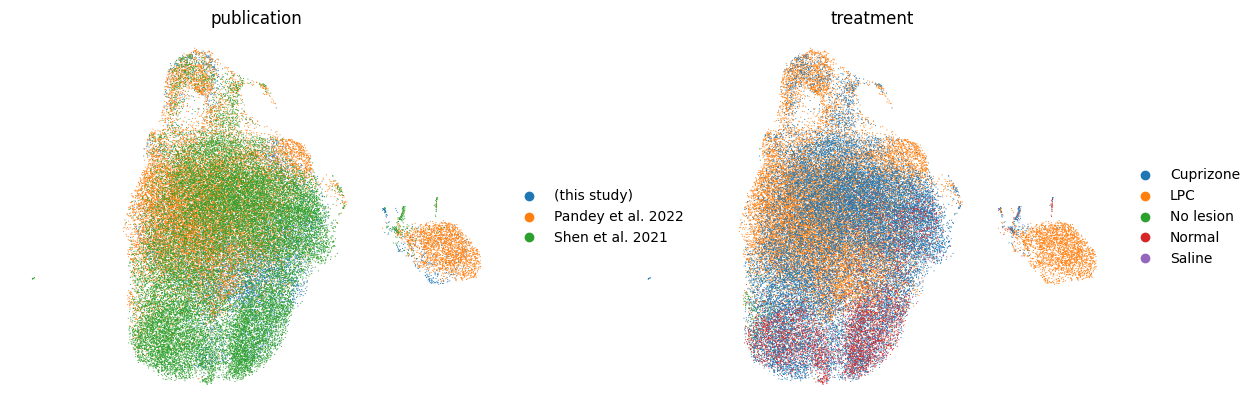

In [53]:
sc.pl.embedding(
    adata_mg,
    basis='X_umap',
    color=["publication", "treatment"],
    frameon=False,
    ncols=2,
)

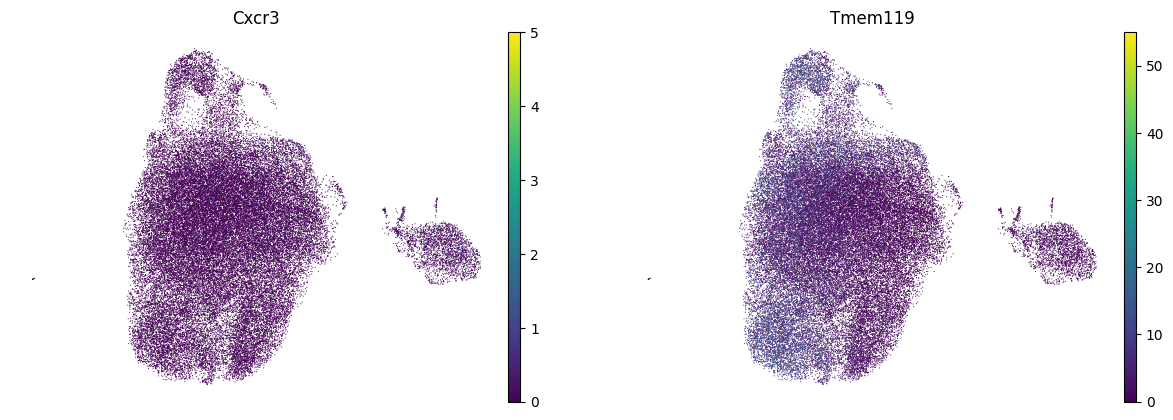

In [69]:
sc.pl.embedding(
    adata_mg,
    basis='X_umap',
    color=["Cxcr3", "Tmem119"],
    frameon=False,
    ncols=2,
    use_raw=True
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

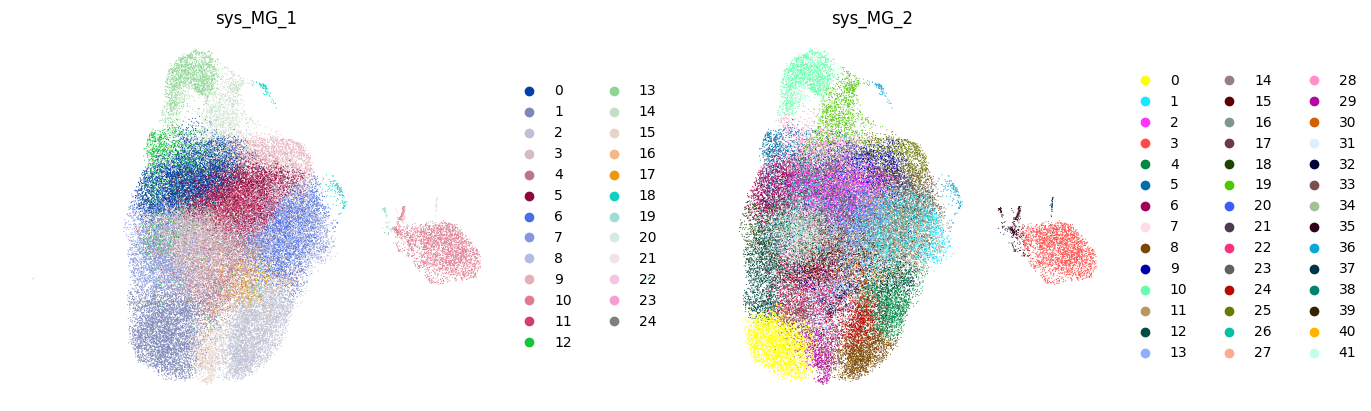

In [52]:
sc.pl.embedding(
    adata_mg,
    basis='X_umap',
    color=["sys_MG_1", "sys_MG_2"],
    frameon=False,
    ncols=2,
)

# Astrocytes and neuroblasts

In [54]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['cell_type_eval'].unique()
for condition in unique_conditions:
    print(condition)

excitatory neurons

inhibitory neurons

oligodendrocytes

astrocytes

microglia

opcs + cops

mixed ol + microglia

neuroblasts

ependymal

endo + peri

unknown

choroid plexus

vsmcs

In [55]:
desired_cell_types = ['astrocytes', 'neuroblasts']
adata_as = adata[adata.obs['cell_type_eval'].isin(desired_cell_types)].copy()
sc.pp.filter_genes(adata_as, min_cells=1)
adata_as

AnnData object with n_obs × n_vars = 3891 × 5914
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariate_categ_orders', 'covaria

In [56]:
sc.pp.neighbors(adata_as, use_rep="X_sysVI")
sc.tl.umap(adata_as)
sc.tl.leiden(adata_as, resolution=1, key_added="sys_AS_1")
sc.tl.leiden(adata_as, resolution=2, key_added="sys_AS_2")

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

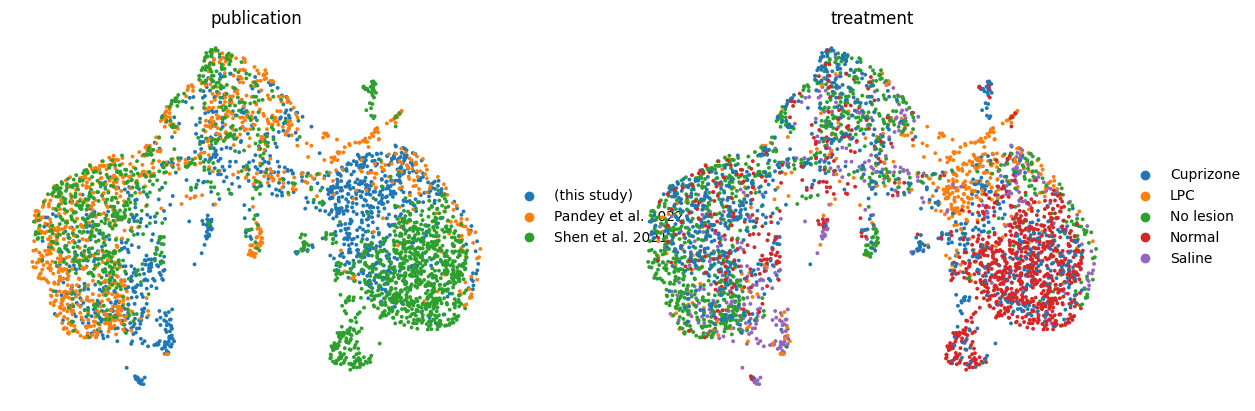

In [57]:
sc.pl.embedding(
    adata_as,
    basis='X_umap',
    color=["publication", "treatment"],
    frameon=False,
    ncols=2,
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seei

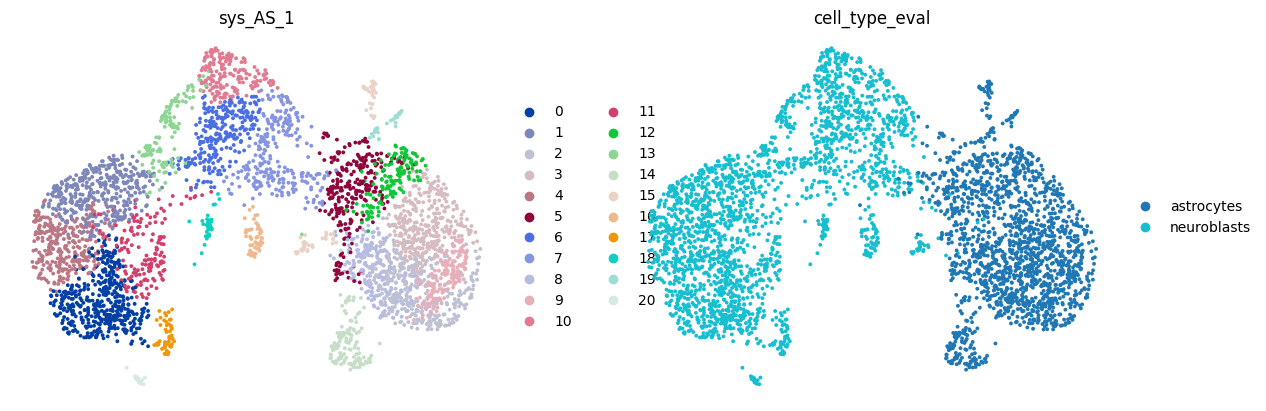

In [59]:
sc.pl.embedding(
    adata_as,
    basis='X_umap',
    color=["sys_AS_1", "cell_type_eval"],
    frameon=False,
    ncols=2,
)

In [70]:
adata_as

AnnData object with n_obs × n_vars = 3891 × 5914
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'system_map', 'sys_leiden_0.5', 'sys_leiden_1', 'sys_leiden_1.5', 'sys_leiden_2', 'sys_AS_1', 'sys_AS_2'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_eval_colors', 'covariate

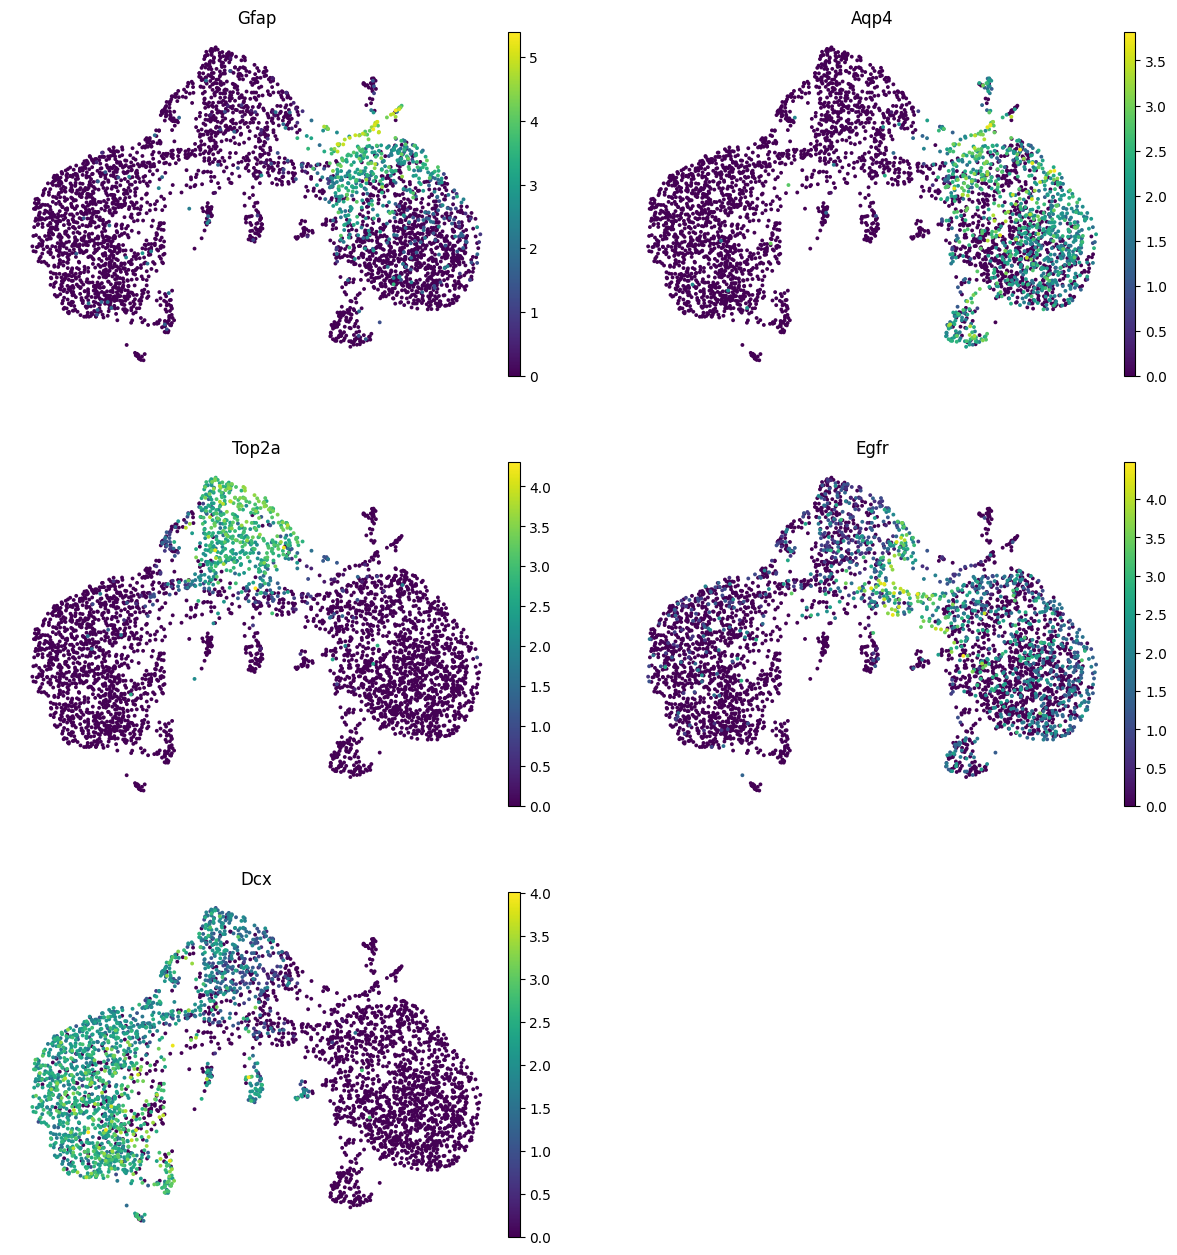

In [64]:
sc.pl.embedding(
    adata_as,
    basis='X_umap',
    color=["Gfap", "Aqp4", "Top2a", "Egfr", "Dcx"],
    frameon=False,
    ncols=2,
    layer='log1p_norm'
)

In [71]:
adata_mg.write_h5ad('./sysVI_mouse_only_MG.h5ad')

In [72]:
adata_as.write_h5ad('./sysVI_mouse_only_AS.h5ad')